In [1]:
import os
import time
import torch
import random
import numpy as np
from torch import nn
from torch.functional import F
from matplotlib import pyplot as plt
from torchvision.transforms import v2
from torchvision.datasets import FashionMNIST
from torchvision.io import read_image
from torch.utils.data import DataLoader, Subset, Dataset
from torchsummary import summary
from rich.progress import Progress

In [2]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((32, 32), interpolation=v2.InterpolationMode.BILINEAR)
    ]
)

In [3]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = [os.path.join(img_dir, i) for i in os.listdir(img_dir)]

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img = read_image(path=f'{self.img_paths[idx]}')

        if self.transform:
            img = self.transform(img)

        return img

In [4]:
train_dataset = CelebADataset('dataset/CelebA/img_align/', transform=transforms)

In [5]:
class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, z_mean, z_log_variance):
        B, C = z_mean.shape
        
        mean = 0
        std = 1
        z_std = 0.5 * torch.exp(z_log_variance)

        eps = torch.normal(mean, std, (B, C))
        eps = eps.to(device)
        z = z_mean + z_std * eps

        return z

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.enc_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(),
        )
        self.enc_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(),
        )
        self.enc_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(),
        )
        self.enc_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(),
        )
        self.enc_5 = nn.Sequential(
            nn.Flatten(),
        )
        self.enc_6 = nn.Linear(in_features=512, out_features=200)
        self.enc_7 = nn.Linear(in_features=512, out_features=200)
        self.enc_8 = Sampling()

    def forward(self, x):
        x = self.enc_1(x)
        x = self.enc_2(x)
        x = self.enc_3(x)
        x = self.enc_4(x)
        x = self.enc_5(x)
        z_mean = self.enc_6(x)
        z_log_variance = self.enc_7(x)
        z = self.enc_8(z_mean, z_log_variance)
        
        return z_mean, z_log_variance, z

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.dec_1 = nn.Sequential(
            nn.Linear(in_features=200, out_features=512),
            nn.BatchNorm1d(num_features=512),
            nn.LeakyReLU(),
            nn.Unflatten(dim=1, unflattened_size=(128, 2, 2))
        )
        self.dec_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(),
        )
        self.dec_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(),
        )
        self.dec_4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(),
        )
        self.dec_5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(),
        )
        self.dec_6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.dec_1(x)
        x = self.dec_2(x)
        x = self.dec_3(x)
        x = self.dec_4(x)
        x = self.dec_5(x)
        x = self.dec_6(x)
        
        return x

In [8]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(VariationalAutoencoder, self).__init__()

        self.ae_1 = encoder
        self.ae_2 = decoder

    def forward(self, x):
        z_mean, z_log_variance, z = self.ae_1(x)
        reconstruction = self.ae_2(z)
        
        return z_mean, z_log_variance, reconstruction

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


In [10]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

model = VariationalAutoencoder(encoder, decoder).to(device)

In [11]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           3,584
       BatchNorm2d-2          [-1, 128, 16, 16]             256
         LeakyReLU-3          [-1, 128, 16, 16]               0
            Conv2d-4            [-1, 128, 8, 8]         147,584
       BatchNorm2d-5            [-1, 128, 8, 8]             256
         LeakyReLU-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]         147,584
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 128, 2, 2]         147,584
      BatchNorm2d-11            [-1, 128, 2, 2]             256
        LeakyReLU-12            [-1, 128, 2, 2]               0
          Flatten-13                  [-1, 512]               0
           Linear-14                  [

In [12]:
learning_rate = 0.001
batch_size = 1024
start_epoch = 0
epochs = 10

In [13]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [14]:
class KLDivAndReconstructionLoss(nn.Module):
    def __init__(self, beta, apply_beta_to='reconstruction'):
        super(KLDivAndReconstructionLoss, self).__init__()
        self.beta = beta
        self.apply_beta_to = apply_beta_to
        self.reconstruction_loss = nn.MSELoss(reduction='none')


    def forward(self, pred, i, z_log_variance, z_mean):
        if self.apply_beta_to == 'kl':
            ce = torch.mean(self.reconstruction_loss(pred, i))
            kl = torch.mean(self.beta * (-0.5 * torch.sum(1 + z_log_variance - torch.pow(z_mean, 2) - torch.exp(z_log_variance), 1)))
        else:
            ce = torch.mean(self.beta * self.reconstruction_loss(pred, i))
            kl = torch.mean(-0.5 * torch.sum(1 + z_log_variance - torch.pow(z_mean, 2) - torch.exp(z_log_variance), 1))

        return ce + kl

In [15]:
loss = KLDivAndReconstructionLoss(beta=2000, apply_beta_to='reconstruction')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def resume(model, filename):
    model.load_state_dict(torch.load(filename, weights_only=True))

In [17]:
# Copied from: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
def train_loop(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0

    for batch, (image) in enumerate(dataloader):
        i = image.to(device)
        z_mean, z_log_variance, reconstruction = model(i)
        
        total_loss = loss(reconstruction, i, z_log_variance, z_mean)
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()

    train_loss /= num_batches
    print(f"Avg. Train loss: {train_loss:>8f}")

In [18]:
# Copied from: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
if start_epoch > 0:
    resume_epoch = start_epoch - 1
    resume(model, f"checkpoints/epoch-{resume_epoch}.pth")

for t in range(start_epoch, epochs):
    t0 = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss, optimizer)
    print(f"Epoch time: {time.time() - t0}\n")
    checkpoint(model, f"checkpoints/epoch-{t}.pth")
print("Done!")

Epoch 1
-------------------------------
Avg. Train loss: 523.658107
Epoch time: 596.991819858551

Epoch 2
-------------------------------
Avg. Train loss: 79.938390
Epoch time: 101.10812044143677

Epoch 3
-------------------------------
Avg. Train loss: 62.715202
Epoch time: 101.11048746109009

Epoch 4
-------------------------------
Avg. Train loss: 54.400098
Epoch time: 101.20813298225403

Epoch 5
-------------------------------
Avg. Train loss: 49.510592
Epoch time: 101.21060419082642

Epoch 6
-------------------------------
Avg. Train loss: 46.145072
Epoch time: 101.08645033836365

Epoch 7
-------------------------------
Avg. Train loss: 44.181852
Epoch time: 101.1785671710968

Epoch 8
-------------------------------
Avg. Train loss: 42.835623
Epoch time: 101.28048801422119

Epoch 9
-------------------------------
Avg. Train loss: 41.644856
Epoch time: 101.16700720787048

Epoch 10
-------------------------------
Avg. Train loss: 40.788337
Epoch time: 101.12967538833618

Done!


In [19]:
subset_indices = [random.randint(0, train_dataset.__len__() - 1) for i in range(10)]
data_subset = Subset(train_dataset, subset_indices)
data_subset_loader = DataLoader(data_subset, batch_size=1, shuffle=True)

In [20]:
def infer_and_plot_results(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    with torch.no_grad():
        for batch, (image) in enumerate(dataloader):
            i = image.to(device)
            z_mean, z_log_variance, reconstruction = model(i)

            prediction = (reconstruction[0] * 255).to(torch.uint8)
            reference = (i[0] * 255).to(torch.uint8)

            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
            fig.supylabel(f'Test Output')
            fig.tight_layout()
            
            ax1.imshow(torch.permute(prediction, (1, 2, 0)).cpu().data.numpy())
            ax1.set_title('Prediction')
            ax2.imshow(torch.permute(reference, (1, 2, 0)).cpu().data.numpy())
            ax2.set_title('Reference')

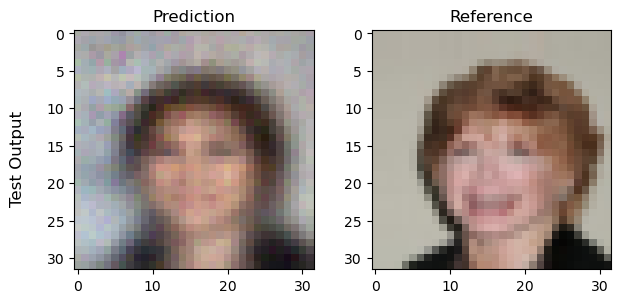

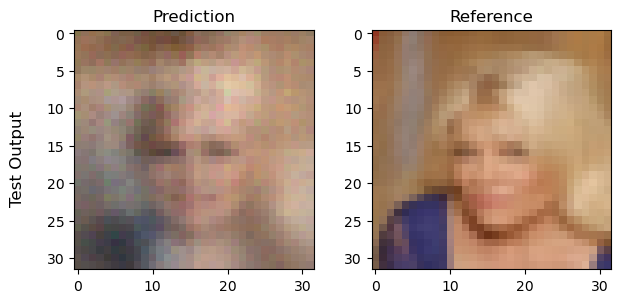

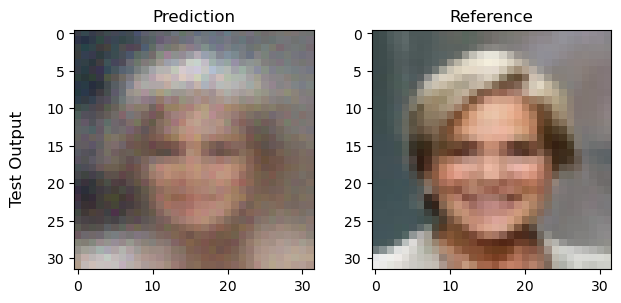

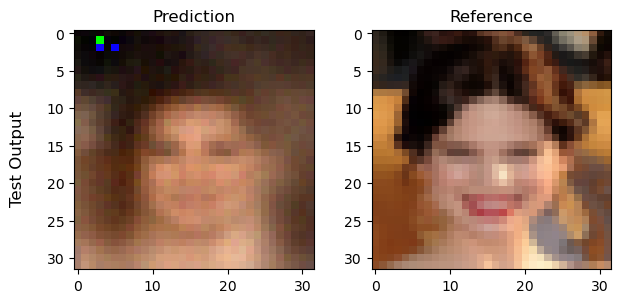

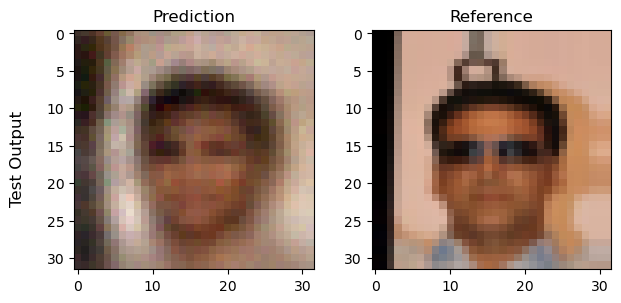

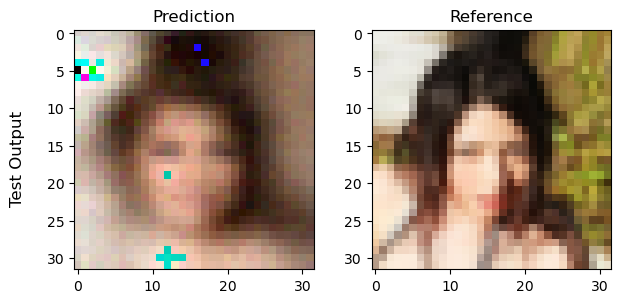

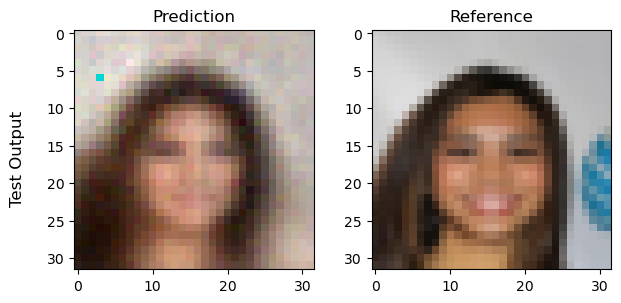

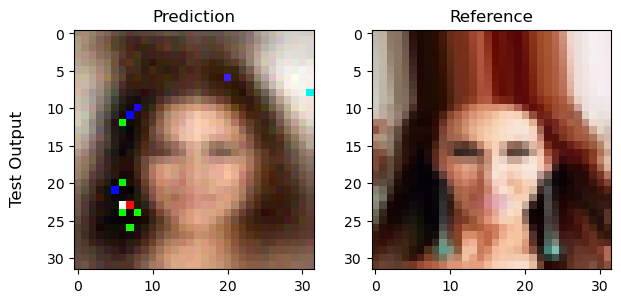

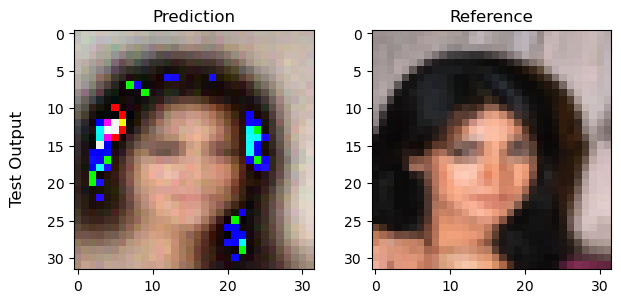

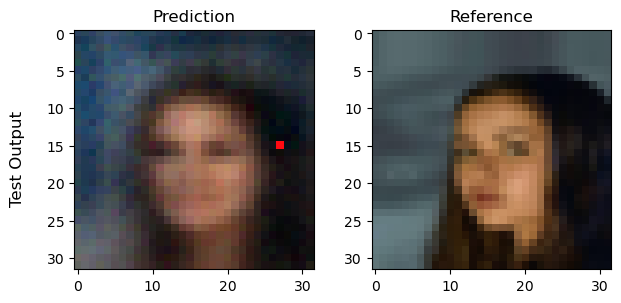

In [21]:
infer_and_plot_results(data_subset_loader, model)

In [22]:
def visualize_latent_space(encoder):
    embeddings = []
    
    for _, (i) in enumerate(train_dataloader):
        i = i.to(device)
        z_mean, z_log_variance, z = encoder(i)
        z = z.cpu().data.numpy()
        embeddings.append(z)

    embeddings = np.concatenate(embeddings)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(x=embeddings[:, 0], y=embeddings[:, 1], s=1, alpha=0.5, c='black')
    plt.show()

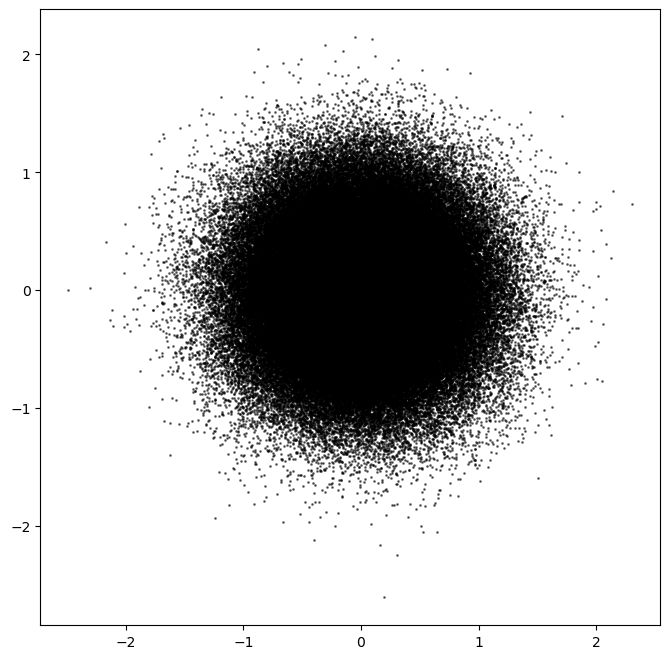

In [23]:
visualize_latent_space(encoder)

In [24]:
def decode_random_sample(decoder):
    embedding = (torch.abs(torch.randn((1, 200))) * 1).to(device)
   
    p = decoder(embedding)
    p = (p[0] * 255).to(torch.uint8)
    p = p.permute((1, 2, 0)).cpu().data.numpy()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(p)
    plt.show()

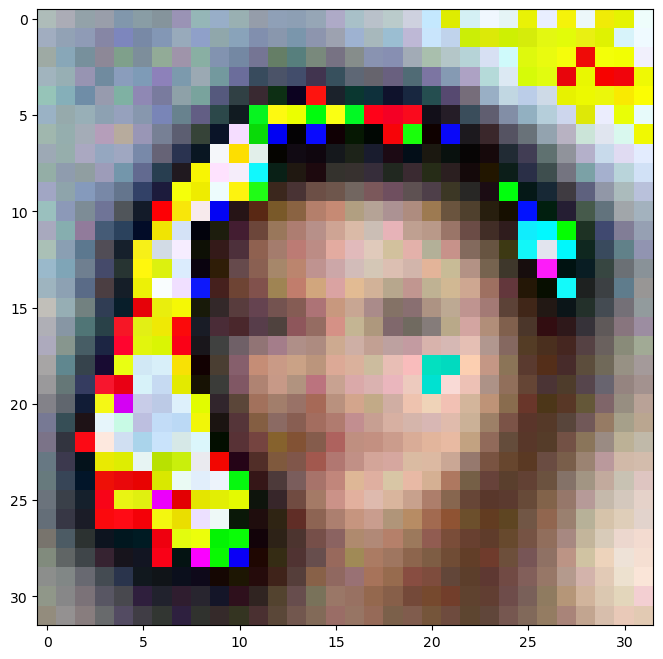

In [25]:
decode_random_sample(decoder)